In [2]:
import logging
import numpy as np
import pandas as pd
import geopandas
import glob
import os
from pyorbital import astronomy
from datetime import datetime, timedelta
from shapely import geometry

In [3]:
def parse_jaxa_hotspot_txt(file_path):
    """
    Parse the JAXA Himawari-8/9 AHI hotspot text and insert into the Pandas DataFrame
    with coordinates, fire radiative power, detection confidence, timestamp and satellite of hotspots.

    Args:
          file_path (str): File path to the JAXA Himawari-8/9 hotspot .csv
    """
    hs_ahi_df = pd.DataFrame()
    cols_to_use_list = [0, 2, *(i for i in range(7,27))]
    date_col_list = [0]
    names_list = ['date', 'satellite', 'lon', 'lat', 'viewzenang', 'viewazang', 'pixwid', 'pixlen', 't07',   
                  't14', 't07_t14', 'meant07', 'meant14', 'meandt', 'sdt07', 'sdt14', 'sddt', 
                  'ref3', 'ref4', 'fire_idx', 'fire', 'test1_6']
    
    print (len(names_list), len(cols_to_use_list))
    

    for file in glob.glob(file_path):
        try:
            f = open(file, "r")
            filename = os.path.basename(file)
            print(filename)
        except Exception as e:
            pass
        
        temp_hs_ahi_df = pd.read_csv(file, sep=",", skiprows=[0], \
                                     header=None, usecols=cols_to_use_list, \
                                     names=names_list, \
                                     parse_dates=date_col_list)

        temp_hs_ahi_df['confidence'] = 'NA'
        temp_hs_ahi_df['FRP'] = 'NA'
        temp_hs_ahi_df['satellite'] = 'Himawari-8/9'

        if len(temp_hs_ahi_df) > 0:
            try:
                temp_hs_ahi_df['solarazang'] = temp_hs_ahi_df.apply( \
                    lambda x: np.degrees(astronomy.get_alt_az(x['date'], x['lon'], x['lat'])[1]), axis=1)
                temp_hs_ahi_df['solarzenang'] = temp_hs_ahi_df.apply( \
                    lambda x: astronomy.sun_zenith_angle(x['date'], x['lon'], x['lat']), axis=1)
                temp_hs_ahi_df['relazang'] = temp_hs_ahi_df['solarazang'] - temp_hs_ahi_df['viewazang']
                temp_hs_ahi_df['sunglint_angle'] = temp_hs_ahi_df.apply(compute_sun_glint_angle, axis=1)
            except Exception as e:
                pass

            try:
                temp_hs_ahi_df.loc[(temp_hs_ahi_df['date'].dt.hour >= 0) \
                                   & (temp_hs_ahi_df['date'].dt.hour <= 11), 'daynight'] = 'day'
                temp_hs_ahi_df.loc[temp_hs_ahi_df['date'].dt.hour > 11, \
                                   'daynight'] = 'night'
                temp_hs_ahi_df['date'] = temp_hs_ahi_df['date'].dt.strftime( \
                    "%d/%m/%Y %H:%M:%S")
            except Exception as e:
                date_from_file = datetime.strptime(filename[4:17], "%Y%m%d_%H%M")
                temp_hs_ahi_df['date'] = date_from_file.strftime("%d/%m/%Y %H:%M:%S")

        hs_ahi_df = pd.concat([hs_ahi_df, temp_hs_ahi_df])

    if len(hs_ahi_df) > 0:
        hs_ahi_df = hs_ahi_df.reset_index(drop=True)

    return hs_ahi_df

In [87]:
hs_df = parse_jaxa_hotspot_txt(file_path="../data/raw/hotspots/ahi/*20190911_0*.csv")

22 22
H08_20190911_0000_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0010_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0020_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0030_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0040_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0050_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0100_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0110_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0120_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0130_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0140_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0150_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0200_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0210_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0220_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0230_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0250_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0300_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0310_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0320_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0330_L2WLFbet_FLDK.06

In [218]:
end_dt = datetime(year=2019, month=9, day=11, hour=7, minute=30)
start_dt = datetime(year=2019, month=9, day=11, hour=2, minute=30)

In [219]:
filter_bool = (hs_df['date'] <= end_dt.strftime(format='%d/%m/%Y %H:%M:00')) & (hs_df['date'] >= start_dt.strftime(format='%d/%m/%Y %H:%M:00'))

In [220]:
hs_df_short = hs_df[filter_bool]

In [221]:
hs_df_short.reset_index(inplace=True, drop=True)

In [222]:
hs_gdf = geopandas.GeoDataFrame(hs_df_short, geometry=geopandas.points_from_xy(hs_df_short.lon, hs_df_short.lat))

In [223]:
hs_gdf.crs = {'init': 'epsg:4326'}
hs_gdf = hs_gdf.to_crs({'init': 'epsg:3857'})
hs_gdf.geometry = hs_gdf.buffer(1)
hs_gdf.head()

,date,satellite,lon,lat,viewzenang,viewazang,pixwid,pixlen,t07,t14,...,fire_idx,fire,test1_6,confidence,FRP,solarazang,solarzenang,relazang,daynight,geometry
0,11/09/2019 02:30:00,Himawari-8/9,117.24,1.94,27.51,94.56,57.550,64.886,321.44,298.43,...,0.1857,1,'001000',NA,NA,82.921620,24.593789,-11.638380,day,"POLYGON ((13051098.101 216001.089, 13051098.09..."
1,11/09/2019 02:30:00,Himawari-8/9,100.74,1.90,46.24,92.32,73.799,106.702,314.41,293.57,...,0.1612,1,'001000',NA,NA,85.011861,41.002803,-7.308139,day,"POLYGON ((11214326.503 211545.808, 11214326.49..."
2,11/09/2019 02:30:00,Himawari-8/9,100.76,1.90,46.22,92.33,73.772,106.624,314.00,294.24,...,0.1002,1,'001000',NA,NA,85.010524,40.982889,-7.319476,day,"POLYGON ((11216552.892 211545.808, 11216552.88..."
3,11/09/2019 02:30:00,Himawari-8/9,101.20,1.58,45.71,91.97,73.096,104.679,330.77,294.97,...,0.8278,1,'011000',NA,NA,84.608267,40.573841,-7.361733,day,"POLYGON ((11265533.468 175907.092, 11265533.46..."
4,11/09/2019 02:30:00,Himawari-8/9,101.20,1.56,45.71,91.95,73.096,104.679,316.53,294.16,...,0.2345,1,'011000',NA,NA,84.585015,40.575725,-7.364985,day,"POLYGON ((11265533.468 173679.866, 11265533.46..."


In [224]:
truth_df = pd.read_csv('../references/qgis_verification/Sep2019/Sep2019_groundtruth.csv')

In [225]:
truth_df.drop(columns=["Unnamed: 0"], inplace=True)
truth_gdf = geopandas.GeoDataFrame(truth_df, geometry=geopandas.points_from_xy(truth_df.lon, truth_df.lat))

In [226]:
truth_gdf.crs = {'init' :'epsg:4326'}
truth_gdf = truth_gdf.to_crs({'init': 'epsg:3857'})

In [227]:
truth_gdf_b500 = truth_gdf.buffer(1000)

In [228]:
truth_gdf.geometry = truth_gdf_b500

In [229]:
truth_gdf.head()

,datestamp,geometry,lat,lon,end_date,start_date,period
0,2019/09/01,"POLYGON ((11372379.424 47734.603, 11372374.609...",0.428803,102.150839,2019-09-01,2019-09-01,0 days 00:00:00.000000000
1,2019/09/01,"POLYGON ((11372513.189 47386.805, 11372508.374...",0.425679,102.152041,2019-09-01,2019-09-01,0 days 00:00:00.000000000
2,2019/09/01,"POLYGON ((11400898.079 -14065.191, 11400893.26...",-0.126350,102.407027,2019-09-01,2019-09-01,0 days 00:00:00.000000000
3,2019/09/01,"POLYGON ((11400068.738 -13984.932, 11400063.92...",-0.125629,102.399577,2019-09-01,2019-09-01,0 days 00:00:00.000000000
4,2019/09/01,"POLYGON ((11401433.139 -14038.438, 11401428.32...",-0.126109,102.411833,2019-09-01,2019-09-01,0 days 00:00:00.000000000


In [230]:
clip_area = geopandas.read_file('../references/qgis_verification/shapefile/Sep_2019.shp')
clip_area.crs
clip_area = clip_area.to_crs({'init': 'epsg:3857'})

In [231]:
hs_df_clipped = geopandas.overlay(clip_area, hs_gdf, how='intersection')

In [232]:
hs_df_clipped.head()

,id,date,satellite,lon,lat,viewzenang,viewazang,pixwid,pixlen,t07,...,fire_idx,fire,test1_6,confidence,FRP,solarazang,solarzenang,relazang,daynight,geometry
0,1,11/09/2019 04:00:00,Himawari-8/9,103.96,-1.3,42.61,88.29,69.353,94.233,317.01,...,0.1491,1,'001000',NA,NA,68.479144,16.374637,-19.810856,day,"POLYGON ((11572775.263 -144727.756, 11572775.2..."
1,1,11/09/2019 04:10:00,Himawari-8/9,104.06,-1.3,42.50,88.28,69.231,93.901,329.70,...,0.7155,1,'011000',NA,NA,64.614400,13.987077,-23.665600,day,"POLYGON ((11583907.212 -144727.756, 11583907.2..."
2,1,11/09/2019 06:40:00,Himawari-8/9,104.02,-1.3,42.55,88.23,69.287,94.051,330.82,...,0.6660,1,'011000',NA,NA,-76.374005,25.492991,-164.604005,day,"POLYGON ((11579454.432 -144727.756, 11579454.4..."
3,1,11/09/2019 05:30:00,Himawari-8/9,104.04,-1.3,42.52,88.25,69.253,93.961,351.44,...,2.0637,1,'011000',NA,NA,-50.821216,9.440320,-139.071216,day,"POLYGON ((11581680.822 -144727.756, 11581680.8..."
4,1,11/09/2019 03:40:00,Himawari-8/9,104.02,-1.3,42.54,88.30,69.275,94.021,323.96,...,0.1447,1,'001000',NA,NA,73.348975,21.049041,-14.951025,day,"POLYGON ((11579454.432 -144727.756, 11579454.4..."


In [233]:
truth_gdf['id_truth'] = truth_gdf.index
truth_gdf.head()

,datestamp,geometry,lat,lon,end_date,start_date,period,id_truth
0,2019/09/01,"POLYGON ((11372379.424 47734.603, 11372374.609...",0.428803,102.150839,2019-09-01,2019-09-01,0 days 00:00:00.000000000,0
1,2019/09/01,"POLYGON ((11372513.189 47386.805, 11372508.374...",0.425679,102.152041,2019-09-01,2019-09-01,0 days 00:00:00.000000000,1
2,2019/09/01,"POLYGON ((11400898.079 -14065.191, 11400893.26...",-0.126350,102.407027,2019-09-01,2019-09-01,0 days 00:00:00.000000000,2
3,2019/09/01,"POLYGON ((11400068.738 -13984.932, 11400063.92...",-0.125629,102.399577,2019-09-01,2019-09-01,0 days 00:00:00.000000000,3
4,2019/09/01,"POLYGON ((11401433.139 -14038.438, 11401428.32...",-0.126109,102.411833,2019-09-01,2019-09-01,0 days 00:00:00.000000000,4


In [285]:
overlaid_gdf_ungrp = geopandas.overlay(truth_gdf, hs_df_clipped, how='union')
overlaid_gdf_ungrp.head()

,datestamp,lat_1,lon_1,end_date,start_date,period,id_truth,id,date,satellite,...,fire_idx,fire,test1_6,confidence,FRP,solarazang,solarzenang,relazang,daynight,geometry
0,2019/09/01,-0.125629,102.399577,2019-09-01,2019-09-01,0 days 00:00:00.000000000,3.0,1.0,11/09/2019 04:50:00,Himawari-8/9,...,0.1304,1.0,'001000',NA,NA,41.924375,6.441897,-47.935625,day,"POLYGON ((11399116.857 -13358.349, 11399116.85..."
1,2019/09/06,-0.124484,102.395798,2019-09-06,2019-09-06,0 days 00:00:00.000000000,1075.0,1.0,11/09/2019 04:50:00,Himawari-8/9,...,0.1304,1.0,'001000',NA,NA,41.924375,6.441897,-47.935625,day,"POLYGON ((11399116.857 -13358.349, 11399116.85..."
2,2019/09/06,-0.127922,102.401987,2019-09-06,2019-09-06,0 days 00:00:00.000000000,1076.0,1.0,11/09/2019 04:50:00,Himawari-8/9,...,0.1304,1.0,'001000',NA,NA,41.924375,6.441897,-47.935625,day,"POLYGON ((11399116.857 -13358.349, 11399116.85..."
3,2019/09/08,-0.115421,102.405331,2019-09-08,2019-09-08,0 days 00:00:00.000000000,1326.0,1.0,11/09/2019 04:50:00,Himawari-8/9,...,0.1304,1.0,'001000',NA,NA,41.924375,6.441897,-47.935625,day,"POLYGON ((11399116.857 -13358.349, 11399116.85..."
4,2019/09/01,-0.125629,102.399577,2019-09-01,2019-09-01,0 days 00:00:00.000000000,3.0,1.0,11/09/2019 05:00:00,Himawari-8/9,...,0.1004,1.0,'001000',NA,NA,20.701423,5.117264,-69.158577,day,"POLYGON ((11399116.857 -13358.349, 11399116.85..."


In [286]:
overlaid_gdf_ungrp['datestamp'].unique()

array(['2019/09/01', '2019/09/06', '2019/09/08', '2019/09/03',
       '2019/09/07', '2019/09/04', '2019/09/05', '2019/09/02',
       '2019/09/10', '2019/09/12', '2019/09/11', '2019/09/09', nan],
      dtype=object)

In [287]:
overlaid_gdf_ungrp = overlaid_gdf_ungrp[(overlaid_gdf_ungrp['datestamp'] == '2019/09/11') | overlaid_gdf_ungrp['datestamp'].isna()]

In [288]:
overlaid_gdf_ungrp['lat_1'].isna().sum()

7807

In [291]:
overlaid_gdf_ungrp['truth_flag'] = 1
overlaid_gdf_ungrp.loc[overlaid_gdf_ungrp['lat_2'].isna(), 'truth_flag'] = 0
overlaid_gdf_ungrp.loc[overlaid_gdf_ungrp['lat_1'].isna(), 'truth_flag'] = 0

In [292]:
%matplotlib inline
overlaid_gdf_ungrp['truth_flag'].describe()

count    12700.00000
mean         0.34937
std          0.47679
min          0.00000
25%          0.00000
50%          0.00000
75%          1.00000
max          1.00000
Name: truth_flag, dtype: float64

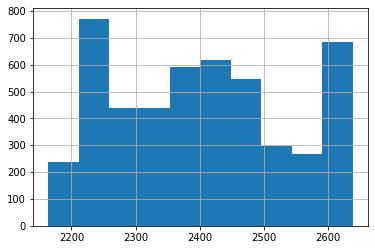

In [243]:
overlaid_gdf_ungrp['id_truth'].hist()

In [244]:
final_gdf = overlaid_gdf_ungrp.dropna(axis=0, subset=['truth_flag'])

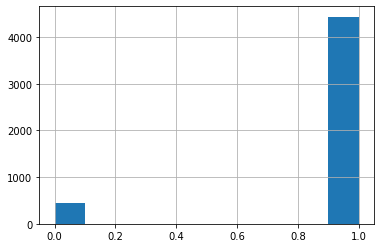

In [248]:
final_gdf['truth_flag'].hist()

In [258]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = final_gdf[final_gdf.truth_flag==1]
df_minority = final_gdf[final_gdf.truth_flag==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample without replacement
                                 n_samples=len(df_majority),     # to match majority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_minority_upsampled, df_majority])

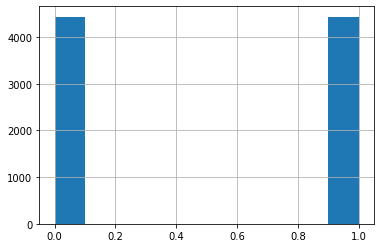

In [259]:
df_balanced['truth_flag'].hist()

In [257]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [264]:
logisticRegr = LogisticRegression(fit_intercept=True, penalty='none', solver='newton-cg')

df_balanced[['t07', 't14', 't07_t14', 'meant07', 'meant14', 'meandt', 'sdt07', 'sdt14', 'sddt', 'ref3', 'ref4', 'solarzenang']].head()

,t07,t14,t07_t14,meant07,meant14,meandt,sdt07,sdt14,sddt,ref3,ref4,solarzenang
24451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
